In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import rl_utils
import gym
import multiagent_particle_envs.multiagent.scenarios as scenarios
from multiagent_particle_envs.multiagent.environment import MultiAgentEnv

# 下列代码是下载代码运行所需的环境和一些库
# !git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
# !pip install -e multiagent-particle-envs
sys.path.append("multiagent_particle_envs")
# # 由于multiagent-pariticle-env底层的实现有一些版本问题,因此gym需要改为可用的版本
# !pip install --upgrade gym==0.10.5 -q


# import multiagent.scenarios as scenarios
# from multiagent.environment import MultiAgentEnv

def make_env(scenario_name):
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

Remove MultiagentSimple-v0 from registry
Remove MultiagentSimpleSpeakerListener-v0 from registry


C:\Users\arnol\AppData\Local\Temp\ipykernel_13752\3523482564.py:111: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  torch.tensor([states[i]], dtype=torch.float, device=self.device)


Episode: 100, [-130.2920736418247, 28.870750782083874, 28.870750782083874]


D:\editor\pythonProject\pythonProject1\RL\rl_utils.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done


Episode: 200, [-149.37310828855738, 0.6598878894255971, 0.6598878894255971]
Episode: 300, [-100.01855786205203, 11.255147264867446, 11.255147264867446]
Episode: 400, [-13.42152142258709, -0.31814245251758144, -0.31814245251758144]
Episode: 500, [-13.684616034241516, -5.057439543411774, -5.057439543411774]
Episode: 600, [-12.790554479281036, -4.515918123938338, -4.515918123938338]
Episode: 700, [-11.701905298255825, 0.3880605447013667, 0.3880605447013667]
Episode: 800, [-11.034757485924889, -0.5243662525356536, -0.5243662525356536]
Episode: 900, [-9.909219518861036, 6.080776355617091, 6.080776355617091]
Episode: 1000, [-10.142641762998494, 6.670854873125692, 6.670854873125692]
Episode: 1100, [-10.422698301796363, 6.88165782836697, 6.88165782836697]
Episode: 1200, [-10.739689680173095, 6.857726022023858, 6.857726022023858]
Episode: 1300, [-9.030894614139745, 6.792866820992736, 6.792866820992736]
Episode: 1400, [-9.772593245730235, 6.373619731111862, 6.373619731111862]
Episode: 1500, [-9.

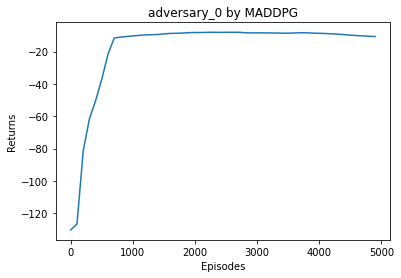

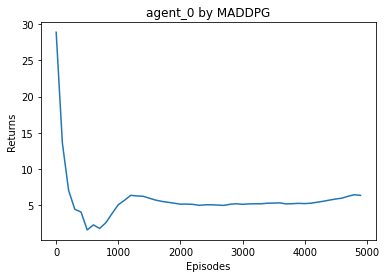

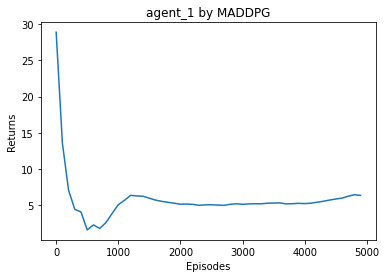

In [2]:
# 让 DDPG 可以适用于离散动作空间的 Gumbel Softmax 采样的相关函数。
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    # logits.shape=torch.Size([1, 5]) 
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()  # tensor([[0., 0., 0., 0., 1.]]
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(
        torch.eye(logits.shape[1])[[np.random.choice(range(logits.shape[1]), size=logits.shape[0])]],requires_grad=False).to(logits.device)  # 创建一个全是1的向量，然后随机从中选一个索引
    # 通过epsilon-贪婪算法来选择用哪个动作
    a=torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in enumerate(torch.rand(logits.shape[0]))])
    return a # tensor([[0., 0., 0., 1., 0.]],shape=(1,5)


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    return y



# 单智能体 DDPG。其中包含 Actor 网络与 Critic 网络，以及计算动作的函数
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1,hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]  # action.shape=(1,5)

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +param.data * tau)
            
            
#  MADDPG 类
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(env.agents))]
        return [agent.take_action(state, explore) for agent, state in zip(self.agents, states)]

    def update(self, sample, i_agent):
        '''  
        i_agent: 第几个智能体
        '''
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(-1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)
            

            
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:  # [Discrete(5), Discrete(5), Discrete(5)] ，每个agent有5个动作
    action_dims.append(action_space.n) # [5, 5, 5]
for state_space in env.observation_space: # [Box(8,), Box(10,), Box(10,)]
    state_dims.append(state_space.shape[0]) # [8, 10, 10]
critic_input_dim = sum(state_dims) + sum(action_dims)  # 43  

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)


            
# 评估策略的方法
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):  # episode_length是每条序列的最大长度
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)  # res.shape=(3)
            rew = np.array(rew)
            returns += rew / n_episode 
    return returns.tolist() # 最终返回的returns为n_episode次rew*episode_length的平均return


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()  # 三个状态，shape分别为(8,) (10,) (10,)
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)  # 采样回来是batch个数据元组
            def stack_array(x):
                '''
                将送进来的数据最后变为shape=(智能体数量，a_dim)
                '''
                rearranged = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))]
                return [torch.FloatTensor(np.vstack(aa)).to(device) for aa in rearranged]
            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        # 一共其实就50个点，但是将坐标轴的间距扩大了100倍
        ep_returns = evaluate(env_id, maddpg, n_episode=100)  
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")
        
        
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(np.arange(return_array.shape[0]) * 100,rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

In [59]:
# 让 DDPG 可以适用于离散动作空间的 Gumbel Softmax 采样的相关函数。
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    # logits.shape=torch.Size([1, 5]) 
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()  # tensor([[0., 0., 0., 0., 1.]]
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(
        torch.eye(logits.shape[1])[[np.random.choice(range(logits.shape[1]), size=logits.shape[0])]],requires_grad=False).to(logits.device)  # 创建一个全是1的向量，然后随机从中选一个索引
    # 通过epsilon-贪婪算法来选择用哪个动作
    a=torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in enumerate(torch.rand(logits.shape[0]))])
    return a # tensor([[0., 0., 0., 1., 0.]],shape=(1,5)


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    return y



# 单智能体 DDPG。其中包含 Actor 网络与 Critic 网络，以及计算动作的函数
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1,hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]  # action.shape=(1,5)

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +param.data * tau)
            
            
#  MADDPG 类
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(env.agents))]
        return [agent.take_action(state, explore) for agent, state in zip(self.agents, states)]

    def update(self, sample, i_agent):
        '''  
        i_agent: 第几个智能体
        '''
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(-1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)
            

            
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:  # [Discrete(5), Discrete(5), Discrete(5)] ，每个agent有5个动作
    action_dims.append(action_space.n) # [5, 5, 5]
for state_space in env.observation_space: # [Box(8,), Box(10,), Box(10,)]
    state_dims.append(state_space.shape[0]) # [8, 10, 10]
critic_input_dim = sum(state_dims) + sum(action_dims)  # 43  

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)


            
# 评估策略的方法
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):  # episode_length是每条序列的最大长度
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)  # res.shape=(3)
            rew = np.array(rew)
            returns += rew / n_episode 
    return returns.tolist() # 最终返回的returns为n_episode次rew*episode_length的平均return


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()  # 三个状态，shape分别为(8,) (10,) (10,)
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)  # 采样回来是batch个数据元组
            def stack_array(x):
                '''
                将送进来的数据最后变为shape=(智能体数量，a_dim)
                '''
#                 # len(x[0]=3/智能体数量,len(x)=batch
                rearranged = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))] 
                return [torch.FloatTensor(np.vstack(aa)).to(device) for aa in rearranged]
            sample = [stack_array(x) for x in sample]  # 这里的x分别是s,a,r,s`,done，他们第一个shape都为batch
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        # 一共其实就50个点，但是将坐标轴的间距扩大了100倍
        ep_returns = evaluate(env_id, maddpg, n_episode=100)  
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")
        
        
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(np.arange(return_array.shape[0]) * 100,rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

Episode: 100, [-155.32622861201475, 29.43106159528153, 29.43106159528153]
Episode: 200, [-160.61369680025945, 3.0477623502433535, 3.0477623502433535]


KeyboardInterrupt: 

In [90]:
sample=replay_buffer.sample(10)
# a,b,c,d,e=sample
# print(a.shape)
# # print(b.shape)
# # print(c.shape)
# print(d.shape)
# print(e)
for x in sample:
    print(len(x[0]))

def stack_array(x):
    '''
    将送进来的数据最后变为shape=(智能体数量，a_dim)
    '''
    rearranged = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))]
    return [torch.FloatTensor(np.vstack(aa)).to(device) for aa in rearranged]
sample = [stack_array(x) for x in sample]

3
3
3
3
3
